# Mini Project 3

By the deadline, please submit the provided Jupyter notebook with all/some required tasks completed and clearly solved. Make sure your code is neat, well-commented, and that all outputs are visible (run all cells before saving). Notebooks with missing tasks or unexecuted cells may receive fewer points. After you submit, you won’t be able to make changes, so double-check your work and be sure to start from the provided template

## Submission rules
As already discussed in class, we will stick to the following rules.
- Use the templates and name your files `NAME_SURNAME.ipynb` (If you have more than one name, just concatenate them). We will compare what you present with that file. 
- Code either not written in Python or not using PyTorch receives a grade of 0. Of course, you can use auxiliary packages when needed (`matplotlib`, `numpy`, ...), but for the learning part, you must use PyTorch.
-  If plagiarism is suspected, TAs and I will thoroughly investigate the situation, and we will summon the student for a face-to-face clarification regarding certain answers they provided. In case of plagiarism, a score reduction will be applied to all the people involved, depending on their level of involvement.
-  If extensive usage of AI tools is detected, we will summon the student for a face-to-face clarification regarding certain answers they provided. If the answers are not adequately supported with in-person answers, we will proceed to apply a penalty to the evaluation, ranging from 10% to 100%.

## Sentiment Analysis with LSTM

The IMDb dataset is a large collection of movie reviews compiled by the Internet Movie Database (IMDb), one of the most comprehensive online databases for films, TV shows, actors, and production crew information. IMDb is widely used for accessing details such as cast lists, user ratings, reviews, and plot summaries [(source)](https://www.geeksforgeeks.org/data-science/imdb-datasets-types-usages-and-application/).

In this mini-project, you will perform **sentiment analysis** on IMDb movie reviews using **LSTM-based models**. The goal is to classify each review as positive or negative.

You are required to build and train:

* A **simple LSTM model**, aiming for at least **75% test accuracy**
* A **more advanced LSTM model**, trying to push the accuracy as high as possible
* A **function** that can evaluate the sentiment of any new review

In [1]:
# Packages here 
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

# Don't change this 
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

/home/luca/miniconda3/envs/DeepLearning/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Task 1 (0 pts)

To load the data, we will use [Hugging Face](https://huggingface.co/), an open-source platform that provides datasets, pre-trained models, and tools for modern machine learning.
**Note:** In principle, you could also use [TorchText](https://docs.pytorch.org/text/main/datasets.html#imdb), but it does not work reliably on Kaggle. Using PyTorch’s dataset instead of Hugging Face is **not** considered an error.

Inspect the dataset you load and make sure you understand its structure and format.

In [2]:
ds = load_dataset("stanfordnlp/imdb")
dataset_train = ds['train']
dataset_test = ds['test']
print(dataset_train)
print()
print(dataset_train['text'][-1])
print(dataset_train['label'][-1])


Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

The story centers around Barry McKenzie who must go to England if he wishes to claim his inheritance. Being about the grossest Aussie shearer ever to set foot outside this great Nation of ours there is something of a culture clash and much fun and games ensue. The songs of Barry McKenzie(Barry Crocker) are highlights.
1


### Task 2 (5 pts)

Split the original **test set** into two parts: a **validation set** and a **final test set**. Use a split of 50-50.

**Note:** We are aware that, in a typical machine learning workflow, you would split the **training set** (not the test set) to create a validation set. However, in this exercise, we intentionally use the test set for this purpose to provide you with **more training data** for model learning.

In [3]:
size = len(dataset_test) // 2
dataset_test , dataset_val = torch.utils.data.random_split(dataset=dataset_test,lengths=[size,size])

### Task 3 (10 pts)

Create a `tokenize` function that takes a line from your dataset (a review) and converts it into tokens.
You may want to consider the following:

* Are `film` and `film.` considered different?
* Does it matter if a word is uppercase or lowercase?
* Should tokens like `<br />` be included or removed?

In [4]:
def tokenize(line):
    line = line.replace('<br />', ' ').replace('<br/>', ' ').replace('<br>', ' ')
    line = line.lower()  #Do I need it?
    tokens = line.split()
    #tokens = [''.join(c for c in token if c.isalpha()) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

### Task 4 (5 pts)
Create two dictionaries, `word_to_idx` and `idx_to_word`, to map words to their embedding indices and vice versa. At this stage, you should decide whether to remove outlier words and replace them with the `<UNK>` token. This decision will, of course, depend on the performance you observe afterward.

In [5]:
word_to_idx = {'<PAD>': 0, '<UNK>': 1}
idx_to_word = {0: '<PAD>', 1: '<UNK>'}

word_counts = {}
for line in dataset_train:
    tokens = tokenize(line['text'])
    for token in tokens:
        word_counts[token] = word_counts.get(token, 0) + 1

min_freq = 3
vocab = [word for word, count in word_counts.items() if count >= min_freq]

for word in vocab:
    idx = len(word_to_idx)
    word_to_idx[word] = idx
    idx_to_word[idx] = word

print(f"Vocabulary size: {len(word_to_idx)}")

Vocabulary size: 67046


### Task 5 (10 pts)
Create a `Dataset` class. The `__getitem__` function should return `(X, y)`, where `X` is a tensor containing the indices of the embedded words, and `y` is a tensor representing the sentiment expressed in the review.


In [6]:
class DatasetIMDB(torch.utils.data.Dataset):
    def __init__(self, dataset, word_to_idx):
        self.dataset = dataset
        self.word_to_idx = word_to_idx

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Handle both HuggingFace Dataset and Subset from random_split
        item = self.dataset[idx]
        if isinstance(item, dict):
            text = item['text']
            label = item['label']
        else:
            # If it's a tuple (from Subset wrapping), unpack it
            text, label = item

        # Tokenize and convert to indices
        tokens = tokenize(text)
        indices = [self.word_to_idx.get(token, self.word_to_idx['<UNK>']) for token in tokens]

        X = torch.tensor(indices, dtype=torch.long)
        y = torch.tensor(label, dtype=torch.float32)

        return (X, y)        

### Task 6 (10 pts)

Define a `collate` function for your DataLoader that ensures all sequences in a batch have the same length. The function should pad shorter sequences with the `<PAD>` index, so that every sequence in the batch matches the length of the longest sequence.

In [7]:
def collate_fn(batch):
    X_batch, y_batch = zip(*batch)
    
    X_padded = pad_sequence(X_batch, batch_first=True, padding_value=word_to_idx['<PAD>'])
    y_batch = torch.tensor(y_batch, dtype=torch.float32)
    
    return X_padded, y_batch

### Task 7 (5 pts)

Create one `DataLoader` for each dataset: Training, Validation, and Test. Make sure each `DataLoader` uses your `Dataset` class and the `collate_fn` function you defined in Task 6.

In [ ]:
batch_size = 64

train_dataloader = DataLoader( DatasetIMDB(dataset_train, word_to_idx), batch_size=batch_size,
                        collate_fn=collate_fn, shuffle=True, num_workers=0)

test_dataloader = DataLoader( DatasetIMDB(dataset_test, word_to_idx), batch_size=batch_size,
                        collate_fn=collate_fn, shuffle=False)  # No need to shuffle test

val_dataloader = DataLoader( DatasetIMDB(dataset_val, word_to_idx), batch_size=batch_size,
                        collate_fn=collate_fn, shuffle=False)  # No need to shuffle validation


### Task 8 (15 pts)

Define an `LSTM` class that can be customized as needed. Follow the provided template, but feel free to add additional attributes or methods if necessary.

In [9]:
class LSTM(torch.nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden_dim=128, num_layers=1, dropout=0, bidirectional=False):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim, padding_idx=word_to_idx['<PAD>'])
        self.lstm = torch.nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,  # dropout only if multiple layers
            bidirectional=bidirectional,
            batch_first=True
        )
        
        self.dropout = torch.nn.Dropout(dropout)
        
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim # If bidirectional, hidden_dim is doubled
        self.fc = torch.nn.Linear(fc_input_dim, 1)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  #(batch_size, seq_len, emb_dim)
        
        # LSTM output: (batch_size, seq_len, hidden_dim * num_directions)
        # hidden: tuple of (h_n, c_n) where h_n shape is (num_layers * num_directions, batch_size, hidden_dim)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        if self.lstm.bidirectional:
            # hidden[-2] is last layer forward, hidden[-1] is last layer backward
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1) # If bidirectional, concatenate forward and backward hidden states
        else:
            hidden = hidden[-1]
        
        hidden = self.dropout(hidden)
        output = self.fc(hidden) # (batch_size, 1)
        
        return output.squeeze(1)  # (batch_size,)

### Task 9 (30 pts)

Train your model. Aim for a **test** accuracy of at least 75%. Be prepared to answer, among others, the following questions:

* Did you use a stacked LSTM? Why or why not?
* Did you use a bidirectional LSTM? Why or why not?
* Did you need to adjust tensor dimensions for your model?
* Which loss function did you choose, and why?

Plot the training and evaluation losses, making sure there are no signs of overfitting, and print the final tarining/validation/test accuracy.

In [10]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTM(
    vocab_size=len(word_to_idx),
    emb_dim=100,
    hidden_dim=128,
    num_layers=2,
    dropout=0.5,
    bidirectional=True
).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCEWithLogitsLoss()

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
print(f"Current GPU: {torch.cuda.current_device()}")

GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU
Current GPU: 0


In [11]:
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            
            outputs = model(x)  # Shape: (batch_size,)
            
            predictions = torch.sigmoid(outputs) > 0.5
            predictions = predictions.float()
            
            correct += (predictions == y).sum().item()
            total += y.size(0)
    accuracy = 100 * correct / total
    return accuracy

In [12]:
def train(model, trainset, valset, num_epochs, optimizer,  criterion, print_every=1, device="cpu"):
    model.train()

    train_loss_hist = []
    val_loss_hist = []


    epoch = 0
    while epoch < num_epochs:
        epoch_loss = 0.0
        epoch += 1
        
        for x, y in trainset:
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            out =  model(x)         # out has dim: batch x seq_length x vocab_size
            # Calculate loss
            loss = criterion(out, y)  # batch x vocab_size x seq_length
            epoch_loss += loss.item()
            # Calculate gradients and update parameters
            loss.backward()
            optimizer.step()

        epoch_loss /= len(trainset)
        train_loss_hist.append(epoch_loss)
        train_acc = evaluate_accuracy(model, trainset, device)

        model.eval()
        epoch_val_loss = 0.0
        
        with torch.no_grad():
            for x, y in valset:
                x = x.to(device)
                y = y.to(device)
                
                out = model(x)
                loss = criterion(out, y)
                epoch_val_loss += loss.item()
        
        epoch_val_loss /= len(valset)
        val_loss_hist.append(epoch_val_loss)
        val_acc = evaluate_accuracy(model,valset, device)

        if print_every and (epoch % print_every) == 0:
            print(f"Epoch: {epoch}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
            print(f"\t  Train accuracy: {train_acc:.2f}%  , Validation accuracy: {val_acc:.2f}% ")

    return train_loss_hist, val_loss_hist

In [13]:
train_loss, val_loss = train(model, train_dataloader, val_dataloader,
                             num_epochs=3, optimizer=optimizer, criterion=loss_fn, device=DEVICE)

test_accuracy = evaluate_accuracy(model, test_dataloader, DEVICE)

print(f"Test Accuracy: {test_accuracy:.2f}%")

OutOfMemoryError: CUDA out of memory. Tried to allocate 116.00 MiB. GPU 0 has a total capacity of 3.80 GiB of which 113.31 MiB is free. Including non-PyTorch memory, this process has 3.68 GiB memory in use. Of the allocated memory 3.53 GiB is allocated by PyTorch, and 63.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

"\n\nplt.figure(figsize=(10, 5))\nplt.plot(train_loss, label='Training Loss')\nplt.plot(val_loss, label='Validation Loss')\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.title('Training and Validation Loss')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

### Task 10 (5 pts)

Improve your model architecture and training procedure by applying one or more of the following strategies:

* Truncated Backpropagation Through Time
* Better tokenizer
* Pre-trained embeddings
* ....

This exercise is considered successful if **any "sensible" improvement in test accuracy** is achieved, even by applying just one change.

In [ ]:
from transformers import AutoTokenizer

# Use a pre-trained tokenizer - DistilBERT is lightweight and effective
tokenizer_improved = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize2(text):
    tokens = tokenizer_improved.tokenize(text)
    return tokens

class DatasetIMDB_improved(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer, max_length=512):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Handle both HuggingFace Dataset and Subset from random_split
        item = self.dataset[idx]
        if isinstance(item, dict):
            text = item['text']
            label = item['label']
        else:
            text, label = item # If it's a tuple (from Subset wrapping), unpack it

        # Use the tokenizer's encode method which:
        # - Tokenizes the text
        # - Converts tokens to IDs
        # - Adds special tokens ([CLS], [SEP])
        # - Truncates to max_length
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt'
        )
        
        # Extract input_ids and remove batch dimension
        X = encoding['input_ids'].squeeze(0)  # Shape: (seq_len,)
        y = torch.tensor(label, dtype=torch.float32)

        return (X, y)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def collate_fn_improved(batch):
    X_batch, y_batch = zip(*batch)
    
    X_padded = pad_sequence(
        X_batch,
        batch_first=True,
        padding_value=tokenizer_improved.pad_token_id
    )
    y_batch = torch.tensor(y_batch, dtype=torch.float32)
    
    return X_padded, y_batch

Vocabulary size: 30522
PAD token ID: 0
Epoch: 1/3, Train Loss: 0.6816, Val Loss: 0.6935
	  Train accuracy: 51.15%  , Validation accuracy: 50.28% 
Epoch: 2/3, Train Loss: 0.6678, Val Loss: 0.6539
	  Train accuracy: 63.92%  , Validation accuracy: 60.70% 
Epoch: 3/3, Train Loss: 0.5446, Val Loss: 0.4259
	  Train accuracy: 84.71%  , Validation accuracy: 81.02% 

Improved Model Test Accuracy: 81.72%


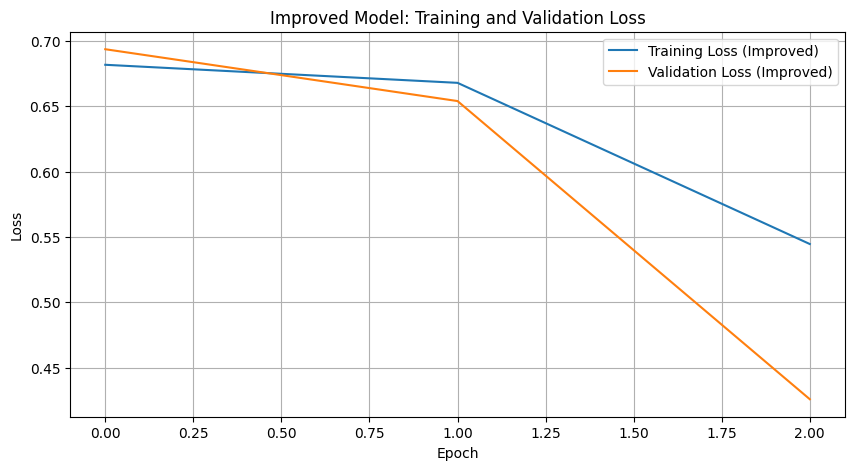

In [ ]:
batch_size_improved = 64
torch.cuda.empty_cache()

# The tokenizer has its own vocabulary, so we don't need word_to_idx
train_dataloader_improved = DataLoader(
    DatasetIMDB_improved(dataset_train, tokenizer_improved, max_length=512),
    batch_size=batch_size_improved,
    collate_fn=collate_fn_improved,
    shuffle=True,
    num_workers=0
)

val_dataloader_improved = DataLoader(
    DatasetIMDB_improved(dataset_val, tokenizer_improved, max_length=512),
    batch_size=batch_size_improved,
    collate_fn=collate_fn_improved,
    shuffle=False
)

test_dataloader_improved = DataLoader(
    DatasetIMDB_improved(dataset_test, tokenizer_improved, max_length=512),
    batch_size=batch_size_improved,
    collate_fn=collate_fn_improved,
    shuffle=False
)

model_improved = LSTM(
    vocab_size=tokenizer_improved.vocab_size,  # ~30k for DistilBERT
    emb_dim=100,
    hidden_dim=128,
    num_layers=2,
    dropout=0.5,
    bidirectional=True
).to(DEVICE)

optimizer_improved = torch.optim.Adam(model_improved.parameters(), lr=0.001)
loss_fn_improved = torch.nn.BCEWithLogitsLoss()

print(f"Vocabulary size: {tokenizer_improved.vocab_size}")
print(f"PAD token ID: {tokenizer_improved.pad_token_id}")

# Train the improved model
train_loss_improved, val_loss_improved = train(
    model_improved,
    train_dataloader_improved,
    val_dataloader_improved,
    num_epochs=3,
    optimizer=optimizer_improved,
    criterion=loss_fn_improved,
    device=DEVICE
)

# Evaluate
test_accuracy_improved = evaluate_accuracy(model_improved, test_dataloader_improved, DEVICE)
print(f"\nImproved Model Test Accuracy: {test_accuracy_improved:.2f}%")

# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(train_loss_improved, label='Training Loss (Improved)')
plt.plot(val_loss_improved, label='Validation Loss (Improved)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Improved Model: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### GPU Memory Management

Check and free GPU memory if needed.

In [ ]:
# Check GPU memory usage
if torch.cuda.is_available():
    print("=== GPU Memory Status ===")
    for i in range(torch.cuda.device_count()):
        print(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")
        print(f"  Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"  Cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
        print(f"  Free: {(torch.cuda.get_device_properties(i).total_memory - torch.cuda.memory_reserved(i)) / 1024**3:.2f} GB")
    
    print("\n=== Memory Summary ===")
    print(torch.cuda.memory_summary(device=DEVICE, abbreviated=True))

In [ ]:
# Solution 1: Clear GPU cache
torch.cuda.empty_cache()
print("✓ GPU cache cleared")

# Solution 2: Delete models and free memory (if you're done with them)
# Uncomment these lines if you want to completely free the GPU:
'''
if 'model' in globals():
    del model
if 'model_improved' in globals():
    del model_improved
torch.cuda.empty_cache()
print("✓ Models deleted and GPU cache cleared")
'''

# Check memory again
if torch.cuda.is_available():
    print(f"\nAfter cleanup:")
    print(f"  Allocated: {torch.cuda.memory_allocated(DEVICE) / 1024**3:.2f} GB")
    print(f"  Cached: {torch.cuda.memory_reserved(DEVICE) / 1024**3:.2f} GB")
    print(f"  Free: {(torch.cuda.get_device_properties(DEVICE).total_memory - torch.cuda.memory_reserved(DEVICE)) / 1024**3:.2f} GB")

### Task 11 (5 pts)

Use one of your trained models to perform sentiment analysis on the following reviews. Be prepared to explain any issues you encountered and how you addressed them.

In [ ]:
ironman = """
Iron Man isn't just a superhero movie. It's the spark that ignited the entire Marvel Cinematic Universe. With Robert Downey Jr.'s career-defining performance, razor-sharp writing, and a perfect blend of heart, humor, and high-tech spectacle, this film redefined what a comic book movie could be.

Even after more than a decade, Iron Man remains one of the most re-watchable, charming, and influential superhero origin stories ever made.

🎬 Overview

Iron Man introduces Tony Stark (Robert Downey Jr.), a brilliant but arrogant billionaire weapons manufacturer. When he's captured by terrorists in Afghanistan and forced to build a missile, Tony instead constructs a powered suit of armor to escape.

Haunted by the destruction caused by his weapons, Stark returns home determined to reinvent himself. Not as a war profiteer, but as Iron Man, a hero powered by his mind, conscience, and an arc reactor in his chest.

Along the way, he faces betrayal from within his company, moral dilemmas, and a growing awareness of what true responsibility means.

✅ What Worked

1. Robert Downey Jr.: Perfect casting. His charisma, wit, and emotional depth made Tony Stark unforgettable.

2. Grounded realism: The technology feels just believable enough to make Iron Man's world plausible.

3. Sharp writing and humor: Smart, fast-paced dialogue that balances action with personality.

4. Emotional arc: Tony's transformation from egocentric arms dealer to self-aware hero feels authentic.

5. Cinematography & effects: The first suit build and flight sequences are still jaw-dropping.

6. Gwyneth Paltrow & Jeff Bridges: Excellent supporting cast. Pepper Potts' loyalty and Obadiah Stane's menace both shine.

7. The ending line: That bold, improvised moment "I am Iron Man." changed superhero cinema forever.

❌ What Didn't Work

1. Final battle pacing: The showdown between Iron Man and Iron Monger feels slightly rushed.

2. Limited female representation: Pepper is great, but she's one of very few women in a male-dominated cast.

3. Predictable villain motivation: Stane's greed is a bit by-the-numbers.

But honestly. These are small cracks in an otherwise near-perfect armor.

💬 Favorite Quotes / Moments

"I am Iron Man." - Tony Stark "Sometimes you've gotta run before you can walk." - Tony Stark "My turn." - Tony, before launching a missile at a tank "Is it better to be feared or respected? I say, is it too much to ask for both?" - Tony Stark Tony's first cave suit escape: gritty, powerful, and unforgettable.

The Mark II flight test: pure cinematic joy as Tony takes to the skies.

Pepper replacing Tony's arc reactor: both funny and intimate.

The press conference ending: Tony discarding the superhero secrecy trope in one iconic line.

The post-credit scene: Nick Fury's appearance teasing the Avengers Initiative (and the MCU as we know it).

💡 Fun Facts

1. Robert Downey Jr. Was not Marvel's first choice but his audition blew everyone away.

2. Much of the film's dialogue was improvised, including "I am Iron Man."

3. The movie was Marvel Studios' first independent production, made before Disney bought them.

4. Jon Favreau insisted on using practical effects for the suits wherever possible.

5. The success of Iron Man directly led to the creation of the MCU, which has since become the highest-grossing franchise in film history.

6. Tony Stark's mansion was CGI. It doesn't actually exist!

🎥 If You Liked This, You Might Also Enjoy

1. The Dark Knight (2008): Another intelligent and grounded superhero reboot.

2. Iron Man 2 (2010): The next chapter in Tony Stark's evolution.

3. Doctor Strange (2016): A spiritual successor exploring genius and redemption.

4. Captain America: The First Avenger (2011): Marvel's other essential origin story.

5. The Social Network (2010): Not a superhero movie, but a study of brilliance and ego that echoes Stark's early character.

Final Thoughts

Iron Man remains the gold standard for superhero origin stories. A perfect fusion of innovation, attitude, and emotion. It's not just about a man in a suit; it's about a man who learns to use his mind and heart for something greater.

Final Verdict: (9.5/10). "The birth of Iron Man was also the birth of a cinematic universe and it still flies higher than ever."
"""

In [ ]:
def predict_sentiment(model, text, word_to_idx, device):
    model.eval()
    
    # Tokenize the text
    tokens = tokenize(text)
    
    # Convert tokens to indices
    indices = [word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens]
    
    # Convert to tensor and add batch dimension
    X = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(X)
        probability = torch.sigmoid(output).item()
    
    sentiment = 'Positive' if probability > 0.5 else 'Negative'
    
    return sentiment, probability

# Predict sentiment for the Iron Man review
sentiment, prob = predict_sentiment(model, ironman, word_to_idx, DEVICE)

print(f"Review: Iron Man")
print(f"Predicted Sentiment: {sentiment}")
print(f"Confidence: {prob:.4f} ({prob*100:.2f}%)")
print(f"\nInterpretation: The model predicts this is a {'POSITIVE' if prob > 0.5 else 'NEGATIVE'} review with {max(prob, 1-prob)*100:.2f}% confidence.")

NameError: name 'model' is not defined

## Questions

During the presentation, we may ask questions to ensure you have understood the core concepts of the course. Examples include:

1.	What is the hidden state in a recurrent neural network (RNN), and what role does it play during sequence processing?
2.	Why do we need padding when working with batches of variable-length sequences? How is padding typically handled in practice?
3.	What is a stacked RNN, and why might stacking multiple recurrent layers improve performance?
4.	What is a bidirectional RNN, and in which scenarios does it provide an advantage?
5.	What is the exploding gradient problem in recurrent networks?
6.	What is the vanishing gradient problem, and why is it particularly severe in RNNs?
7.	What is gradient clipping, and why is it commonly applied when training RNNs?
8.	How do different activation functions influence vanishing or exploding gradients in deep or recurrent networks?
9.	What is truncated backpropagation through time, and why is it used when training RNNs?
10.	What is one-hot encoding for representing words in a vocabulary? What are its limitations?
11.	What does `nn.Embedding` do, and why is it preferred over one-hot encoding?
12.	What are gating mechanisms in recurrent architectures (e.g., LSTM/GRU), and why are they important?
	13.	How do LSTM gates help mitigate the vanishing gradient problem?